In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -q timm
!apt-get install poppler-utils
!pip install pandas pdf2image transformers matplotlib numpy
# Install PaddlePaddle with GPU support
!pip install paddlepaddle-gpu==2.5.1.post112 -f https://www.paddlepaddle.org.cn/whl/stable.html
!pip install paddleocr


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 86.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 1s (175 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 123595 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.5_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.5) ...
Setting up poppler-utils (22.02.0-2ubuntu0.5) ...
Processing triggers for man-db (2.10.2-1) ...
Looking in links: https://www.pa

**Load model**


In [3]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")
model.config.id2label

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

{0: 'table', 1: 'table rotated'}

**load bilan image**

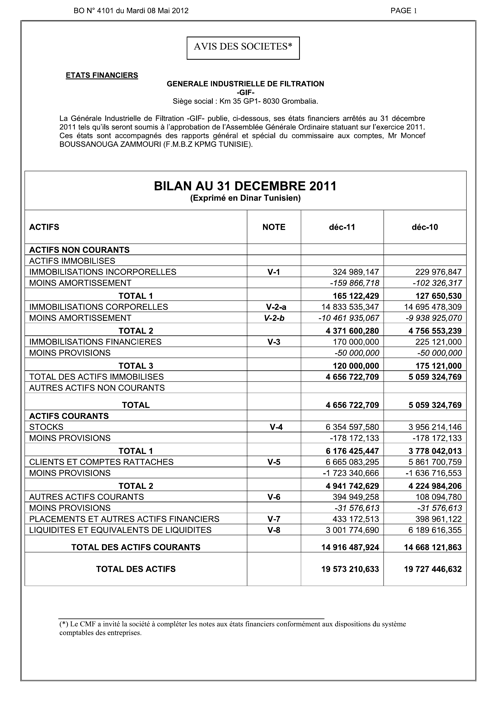

In [32]:
from pdf2image import convert_from_path
from PIL import Image

pdf_path = "/content/exp bilan.pdf"
image = convert_from_path(pdf_path, dpi=300)
image_path = "page_image.png"
image[0].save(image_path, "PNG")

image = Image.open(image_path).convert("RGB")
width, height = image.size

display(image.resize((int(0.2*width), (int(0.2*height)))))
# Resize the image to 50% of its original dimensions
# resized_image = image.resize((int(width * 0.5), int(height * 0.5)))

**preprocessing**

In [10]:
from torchvision import transforms

class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image

detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [33]:
pixel_values = detection_transform(image).unsqueeze(0)
print(pixel_values.shape)

torch.Size([1, 3, 800, 566])


**forward pass**

In [34]:
import torch
import numpy as np

# forward pass
with torch.no_grad():
  outputs = model(pixel_values)

outputs.logits.shape

torch.Size([1, 15, 3])

**Postprocessing**

In [49]:
import torch
import numpy as np
# For output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

# Update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"

def outputs_to_objects(outputs, img_size, id2label):
    # Move outputs to GPU
    logits = outputs.logits.to(device)
    pred_boxes = outputs['pred_boxes'].to(device)

    # Perform softmax and max operations on GPU
    m = logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = pred_boxes.detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects


In [50]:
objects = outputs_to_objects(outputs, image.size, id2label)
print(objects)

[{'label': 'table', 'score': 0.9994716048240662, 'bbox': [142.80850219726562, 1095.7557373046875, 2309.549072265625, 2883.81103515625]}]


**Visualize**

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

def visualize_detected_tables(img, det_tables):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()

    for det_table in det_tables:
        bbox = det_table['bbox']

        if det_table['label'] == 'table':
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        elif det_table['label'] == 'table rotated':
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        else:
            continue

        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor='none', facecolor=facecolor, alpha=0.1)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor=edgecolor, facecolor='none', linestyle='-', alpha=alpha)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=0,
                                    edgecolor=edgecolor, facecolor='none', linestyle='-', hatch=hatch, alpha=0.2)
        ax.add_patch(rect)

    plt.xticks([], [])
    plt.yticks([], [])
    plt.show()

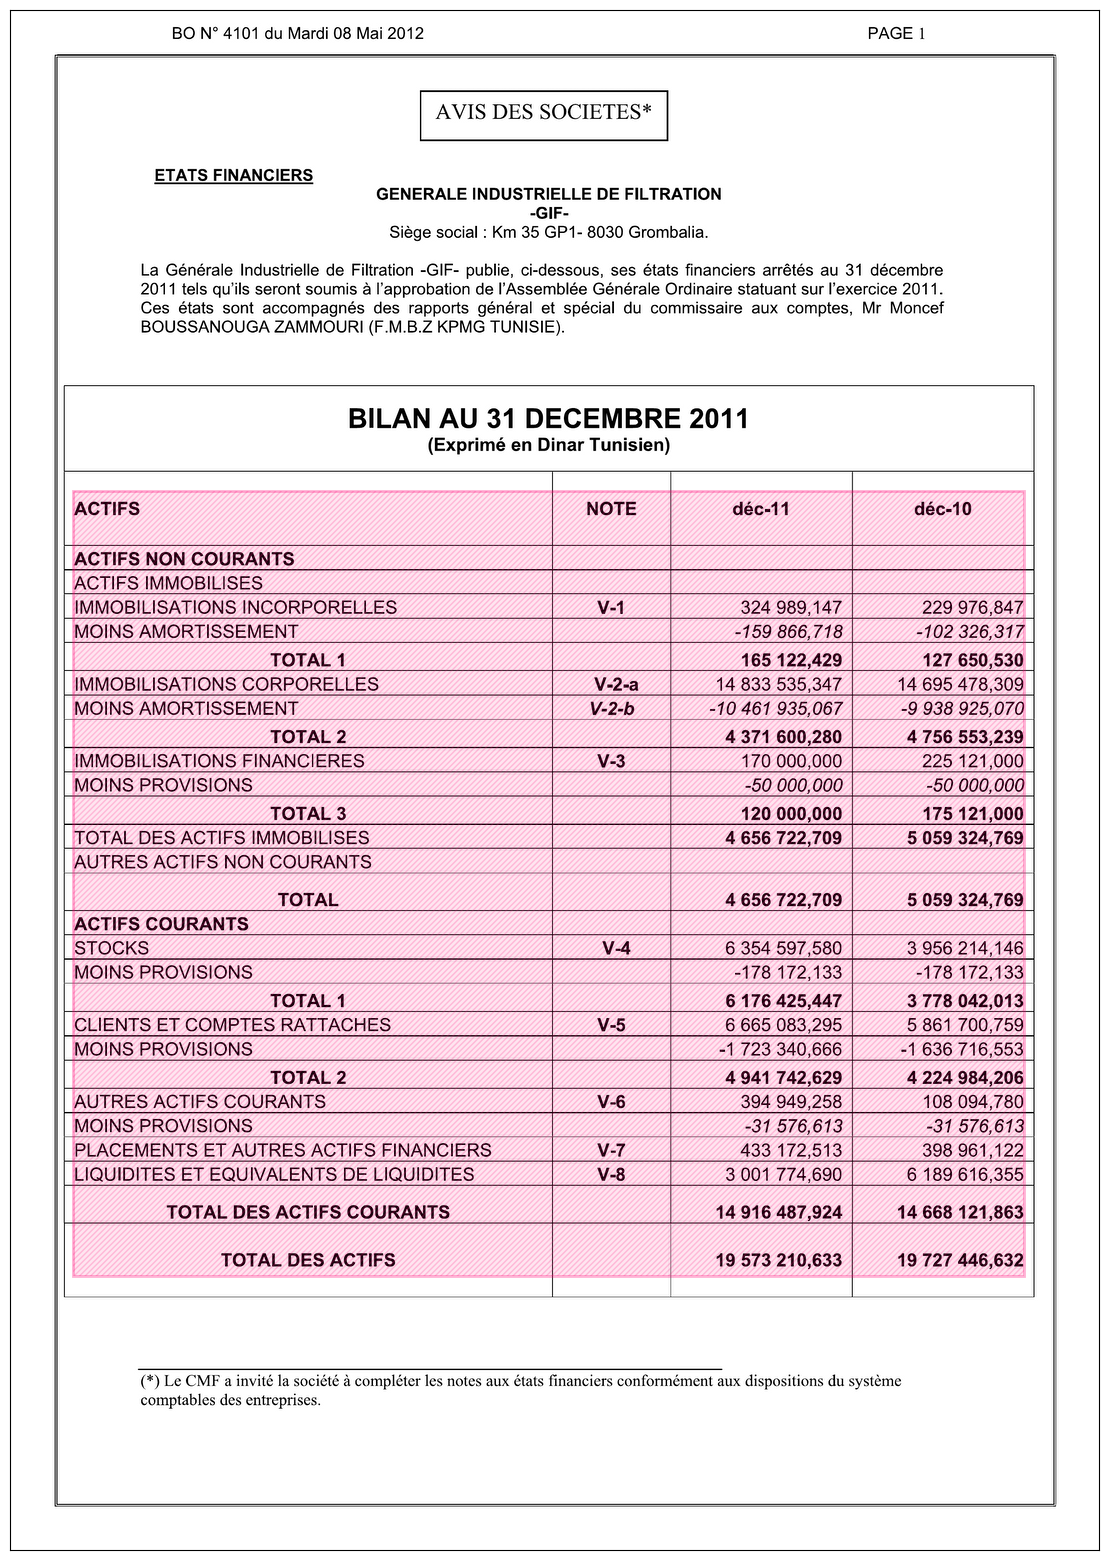

In [51]:
fig = visualize_detected_tables(image, objects)

**crop table**

In [22]:
def objects_to_crops(img, tokens, objects, class_thresholds, padding=10):
    """
    Process the bounding boxes produced by the table detection model into
    cropped table images and cropped tokens.
    """

    table_crops = []
    for obj in objects:
        if obj['score'] < class_thresholds[obj['label']]:
            continue

        cropped_table = {}

        bbox = obj['bbox']
        bbox = [bbox[0]-padding, bbox[1]-padding, bbox[2]+padding, bbox[3]+padding]

        cropped_img = img.crop(bbox)

        table_tokens = [token for token in tokens if iob(token['bbox'], bbox) >= 0.5]
        for token in table_tokens:
            token['bbox'] = [token['bbox'][0]-bbox[0],
                             token['bbox'][1]-bbox[1],
                             token['bbox'][2]-bbox[0],
                             token['bbox'][3]-bbox[1]]

        # If table is predicted to be rotated, rotate cropped image and tokens/words:
        if obj['label'] == 'table rotated':
            cropped_img = cropped_img.rotate(270, expand=True)
            for token in table_tokens:
                bbox = token['bbox']
                bbox = [cropped_img.size[0]-bbox[3]-1,
                        bbox[0],
                        cropped_img.size[0]-bbox[1]-1,
                        bbox[2]]
                token['bbox'] = bbox

        cropped_table['image'] = cropped_img
        cropped_table['tokens'] = table_tokens

        table_crops.append(cropped_table)

    return table_crops


In [53]:
objects

[{'label': 'table',
  'score': 0.9994716048240662,
  'bbox': [142.80850219726562,
   1095.7557373046875,
   2309.549072265625,
   2883.81103515625]}]

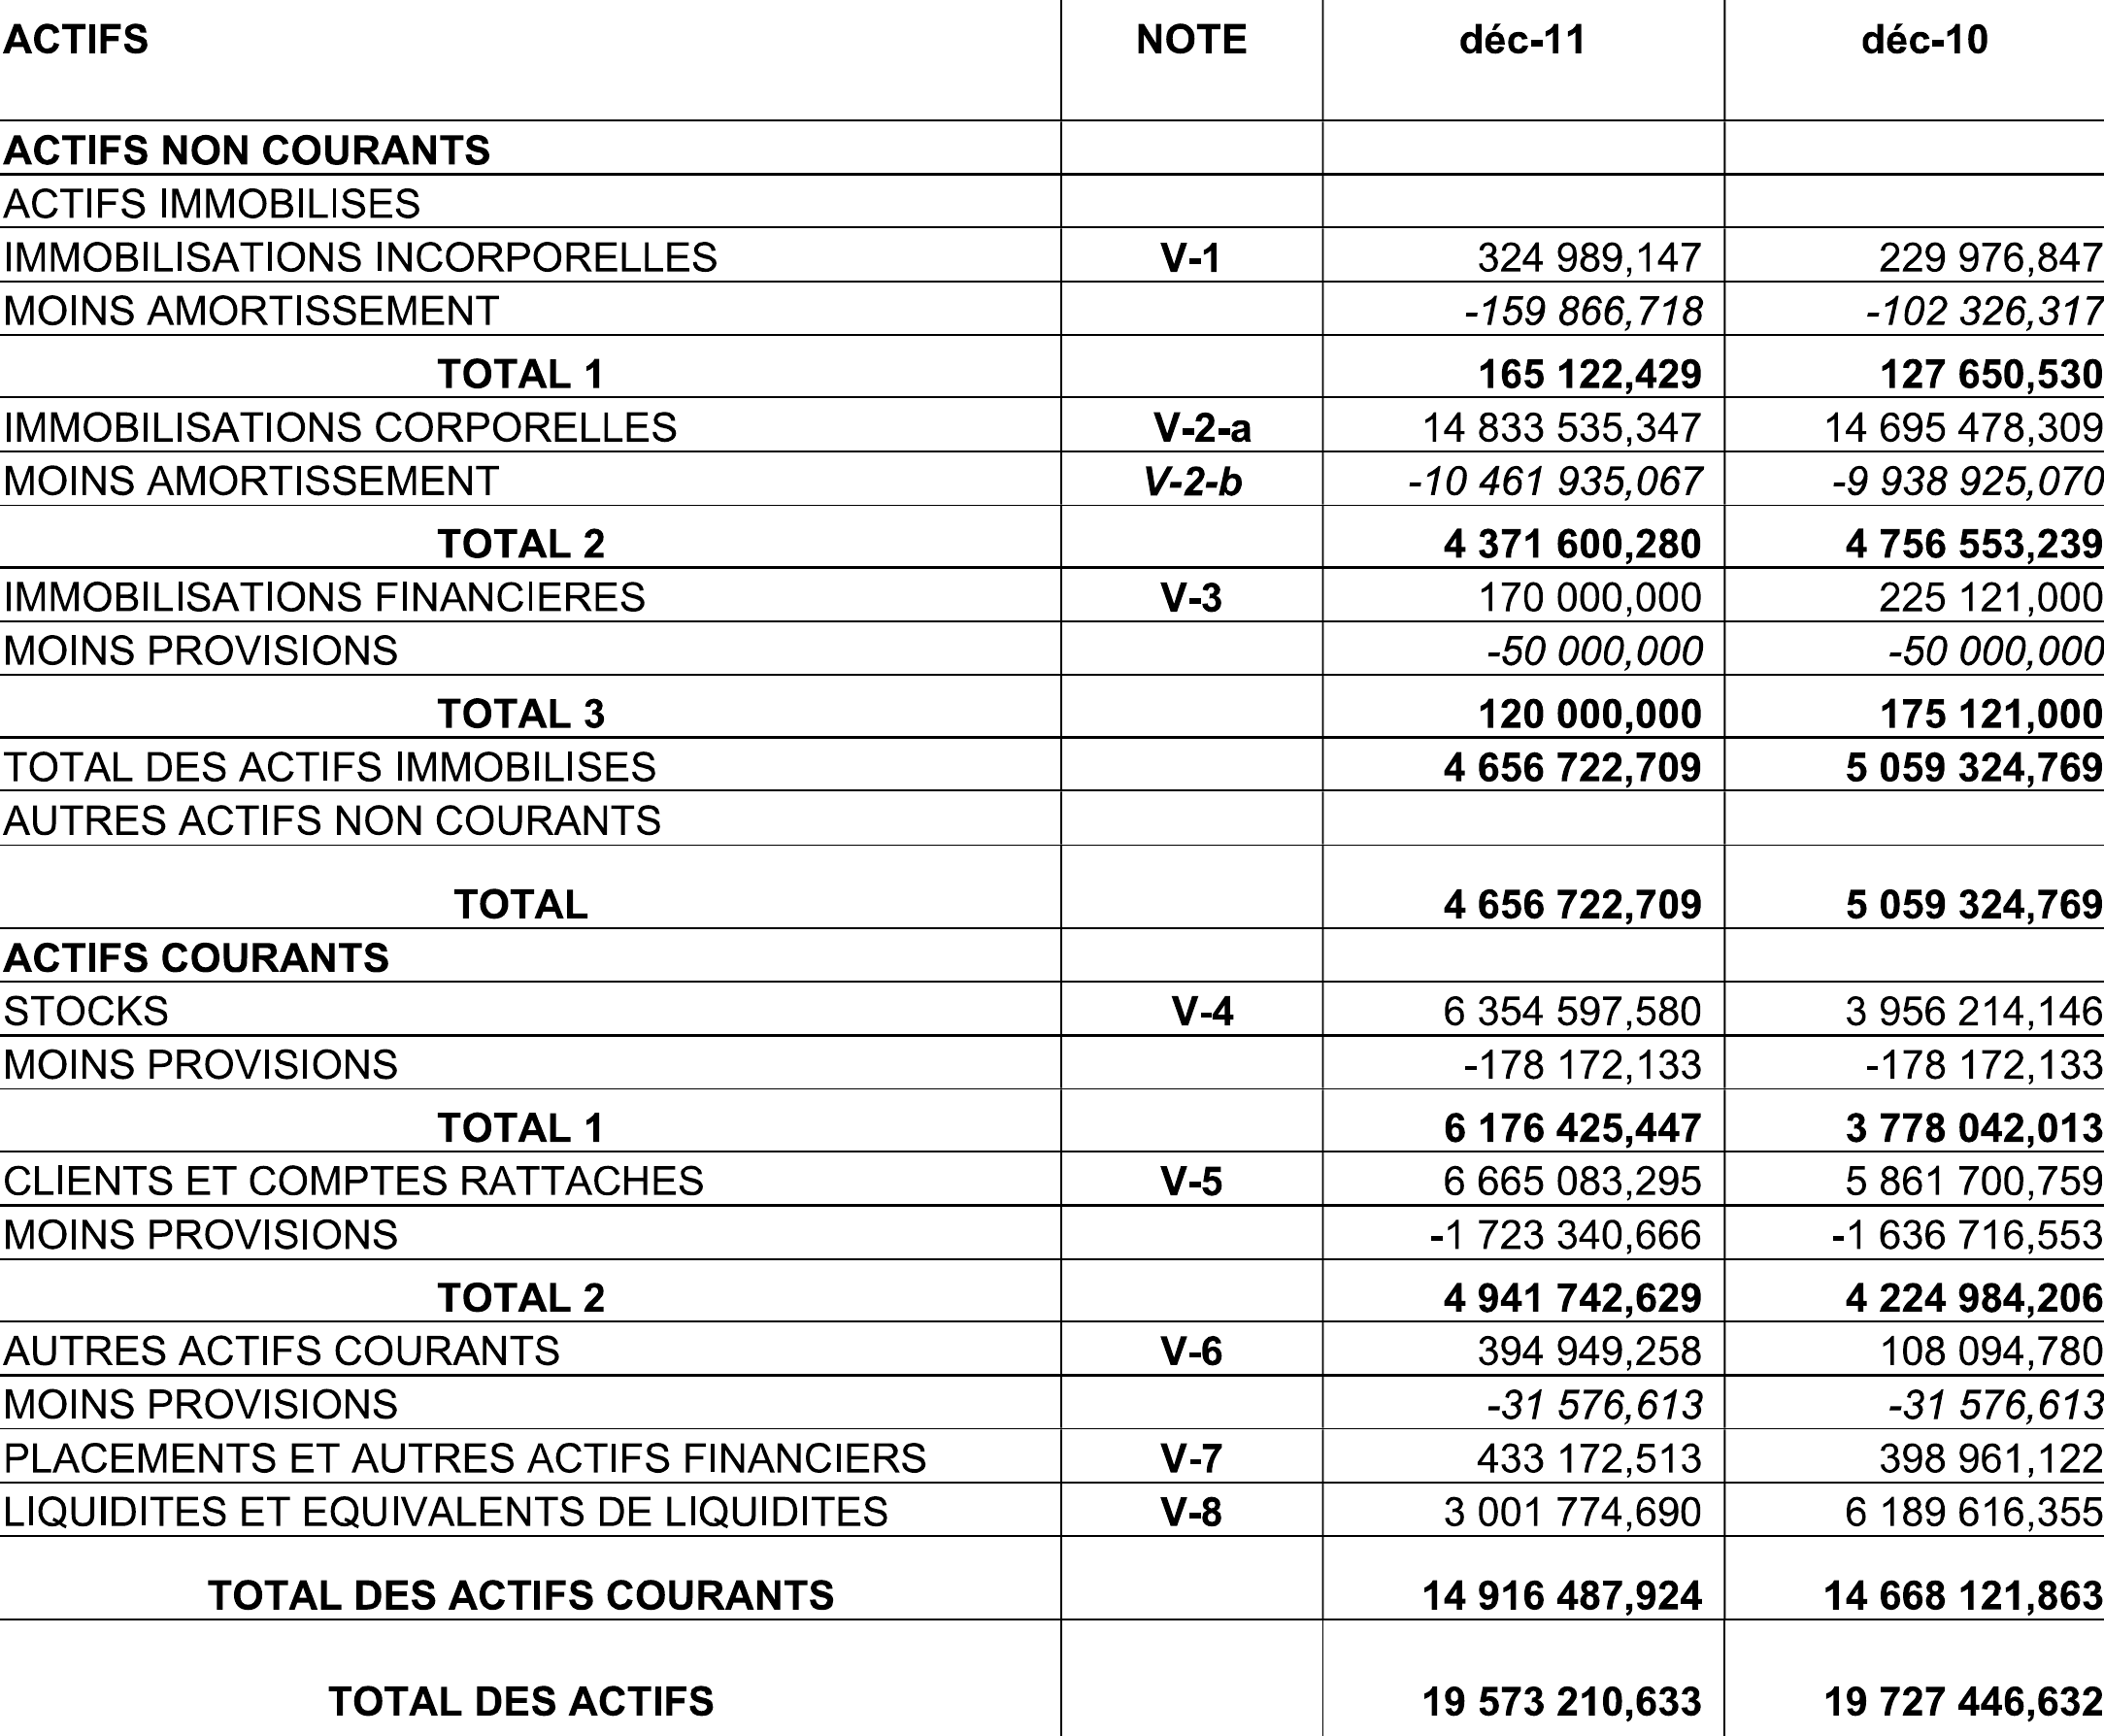

In [54]:
tokens = []
detection_class_thresholds = {
    "table": 0.5,
    "table rotated": 0.5,
    "no object": 10
}
crop_padding = 10

tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=0)
cropped_table = tables_crops[0]['image'].convert("RGB")
cropped_table

**Load structure recognition model**

In [23]:
from transformers import TableTransformerForObjectDetection

# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")

config.json:   0%|          | 0.00/76.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

In [24]:
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [55]:
pixel_values = structure_transform(cropped_table).unsqueeze(0)
print(pixel_values.shape)

torch.Size([1, 3, 825, 1000])


In [56]:
# forward pass
with torch.no_grad():
  outputs = structure_model(pixel_values)

In [57]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)
print(cells)

[{'label': 'table row', 'score': 0.9995713829994202, 'bbox': [0.4059601426124573, 649.2029418945312, 2166.40087890625, 707.7528686523438]}, {'label': 'table column', 'score': 0.9998946189880371, 'bbox': [1060.1290283203125, 13.739777565002441, 1369.1541748046875, 1774.7728271484375]}, {'label': 'table row', 'score': 0.9996680021286011, 'bbox': [0.5170405507087708, 1304.39697265625, 2166.423095703125, 1363.087158203125]}, {'label': 'table projected row header', 'score': 0.657917320728302, 'bbox': [0.6400039792060852, 840.4576416015625, 2165.922607421875, 905.8883666992188]}, {'label': 'table row', 'score': 0.9989853501319885, 'bbox': [0.37844836711883545, 235.60595703125, 2166.3271484375, 293.731201171875]}, {'label': 'table row', 'score': 0.9992613196372986, 'bbox': [0.31987282633781433, 767.2388916015625, 2166.21875, 824.8519897460938]}, {'label': 'table row', 'score': 0.9996147155761719, 'bbox': [0.47441667318344116, 1128.2244873046875, 2166.430419921875, 1186.3004150390625]}, {'labe

**visualize cells**

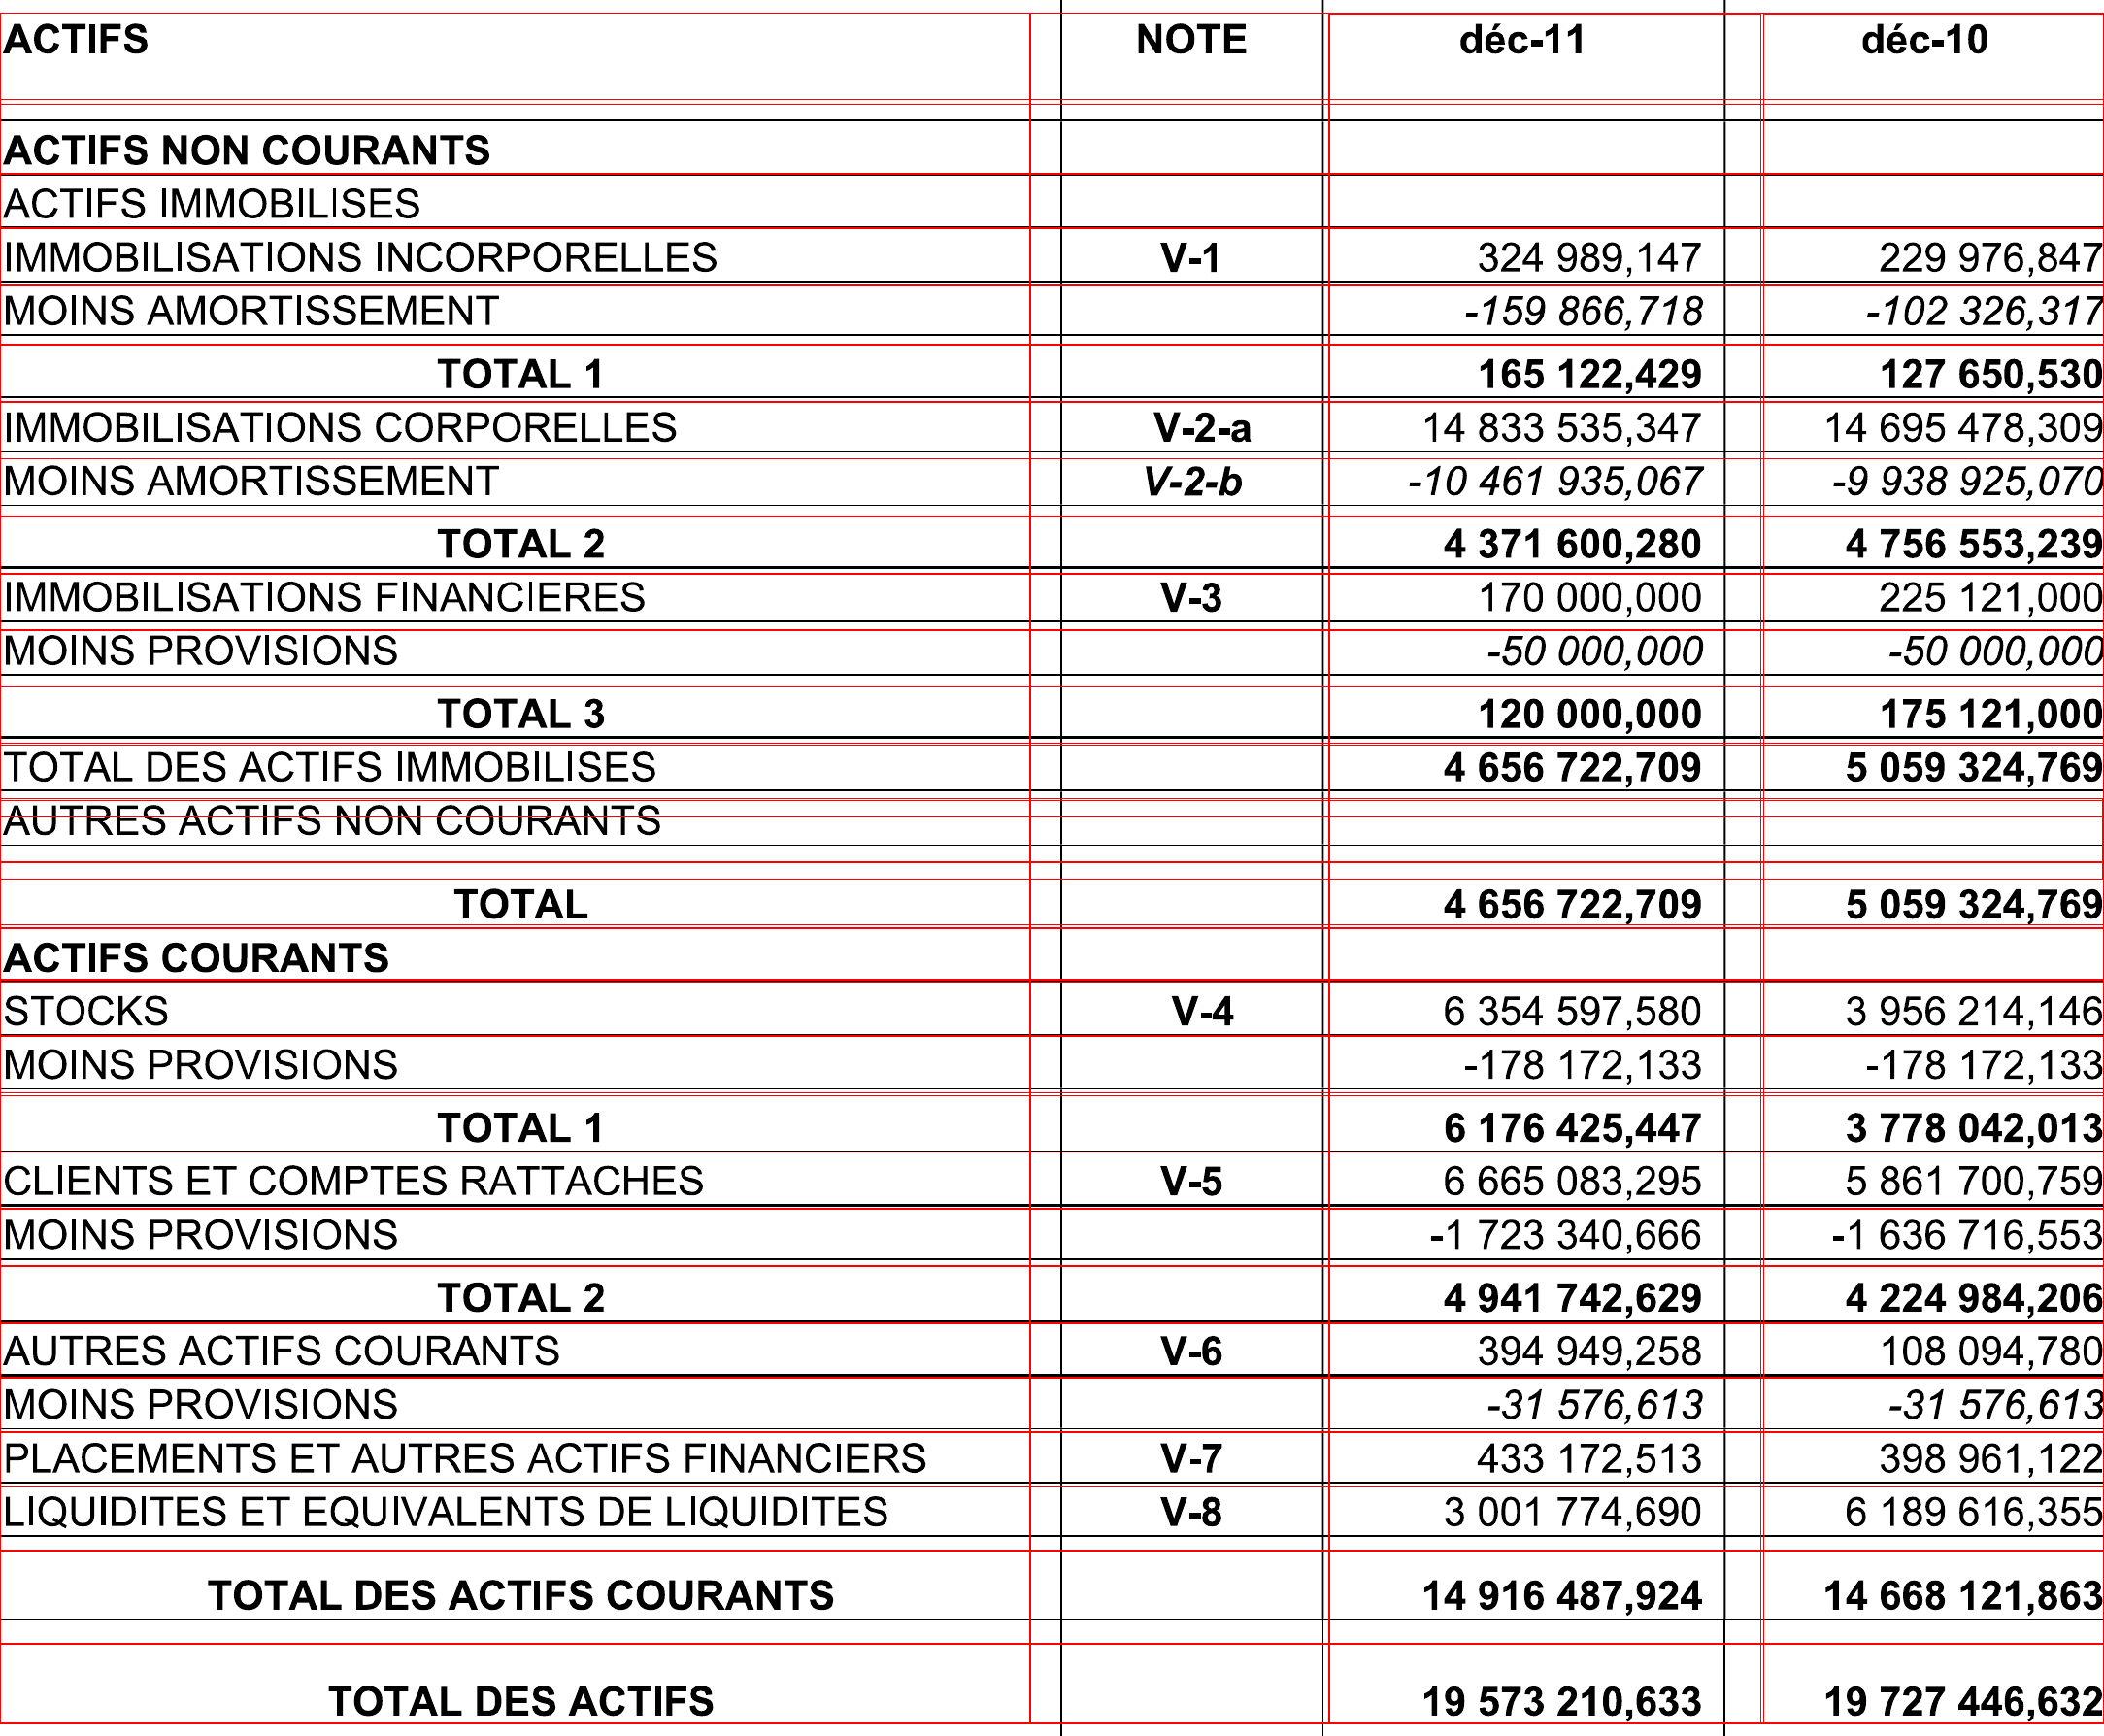

In [58]:
from PIL import ImageDraw

cropped_table_visualized = cropped_table.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")

cropped_table_visualized

In [25]:
def plot_results(cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError("Class should be one of the available classes")

    plt.figure(figsize=(16,10))
    plt.imshow(cropped_table)
    ax = plt.gca()

    for cell in cells:
        score = cell["score"]
        bbox = cell["bbox"]
        label = cell["label"]

        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
          text = f'{cell["label"]}: {score:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
          plt.axis('off')

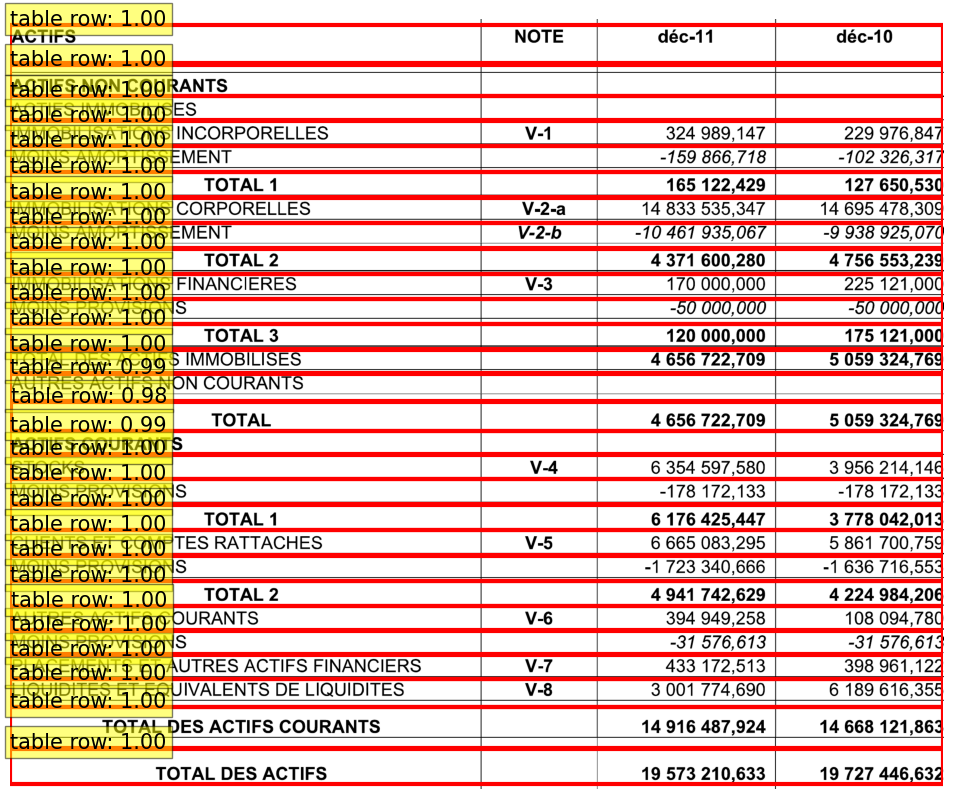

In [59]:
plot_results(cells, class_to_visualize="table row")

**OCR row by row**

In [63]:
!pip install paddleocr paddlepaddle
from paddleocr import PaddleOCR

ocr = PaddleOCR(use_angle_cls=True, lang='fr', use_gpu=True)  # Set use_gpu=True if you're using a GPU


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00
download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:00<00:00, 5.63MiB/s]


download https://paddleocr.bj.bcebos.com/PP-OCRv3/multilingual/latin_PP-OCRv3_rec_infer.tar to /root/.paddleocr/whl/rec/latin/latin_PP-OCRv3_rec_infer/latin_PP-OCRv3_rec_infer.tar


100%|██████████| 10.2M/10.2M [00:04<00:00, 2.12MiB/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:00<00:00, 3.71MiB/s]

[2024/08/25 23:39:36] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/latin/latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25,

In [28]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']

    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'column': column['bbox'], 'cell': cell_bbox})

        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x['column'][0])

        # Append row information to cell_coordinates
        cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})

    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x['row'][1])

    return cell_coordinates

In [64]:
cell_coordinates = get_cell_coordinates_by_row(cells)

In [65]:
len(cell_coordinates)

28

In [66]:
for row in cell_coordinates:
  print(row["cells"])

[{'column': [-0.9998205304145813, 13.364267349243164, 1061.3079833984375, 1774.3948974609375], 'cell': [-0.9998205304145813, 13.578166007995605, 1061.3079833984375, 102.70954132080078]}, {'column': [1060.1290283203125, 13.739777565002441, 1369.1541748046875, 1774.7728271484375], 'cell': [1060.1290283203125, 13.578166007995605, 1369.1541748046875, 102.70954132080078]}, {'column': [1368.31884765625, 14.291133880615234, 1813.3087158203125, 1774.910400390625], 'cell': [1368.31884765625, 13.578166007995605, 1813.3087158203125, 102.70954132080078]}, {'column': [1816.8785400390625, 14.102659225463867, 2167.203369140625, 1774.6226806640625], 'cell': [1816.8785400390625, 13.578166007995605, 2167.203369140625, 102.70954132080078]}]
[{'column': [-0.9998205304145813, 13.364267349243164, 1061.3079833984375, 1774.3948974609375], 'cell': [-0.9998205304145813, 107.32431030273438, 1061.3079833984375, 179.30296325683594]}, {'column': [1060.1290283203125, 13.739777565002441, 1369.1541748046875, 1774.7728

In [76]:
from tqdm.auto import tqdm
def apply_ocr(cell_coordinates, cropped_table):
    # Initialize a dictionary to store the extracted data
    data = dict()
    max_num_columns = 0

    # Iterate over each row in the table
    for idx, row in enumerate(tqdm(cell_coordinates, desc="Processing Rows")):
        row_text = []

        # Iterate over each cell in the row
        for cell in row["cells"]:
            # Crop cell out of the image using PIL
            cell_image = np.array(cropped_table.crop(cell["cell"]))

            # Apply OCR to the cropped cell image
            result = ocr.ocr(cell_image, cls=True)

            # Extract text if any result is found
            if result and result[0]:  # Check if result[0] is not empty
                # PaddleOCR returns a nested list structure
                text = " ".join([line[1][0] for line in result[0]])
                row_text.append(text)

        # Update maximum number of columns
        if len(row_text) > max_num_columns:
            max_num_columns = len(row_text)

        # Store the row's extracted text
        data[idx] = row_text

    print("Max number of columns:", max_num_columns)

    # Pad rows that don't have the maximum number of columns
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
            row_data.extend([""] * (max_num_columns - len(row_data)))
        data[row] = row_data

    return data

In [77]:
data = apply_ocr(cell_coordinates, cropped_table)

Processing Rows:   0%|          | 0/28 [00:00<?, ?it/s]

[2024/08/25 23:45:52] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.16635751724243164
[2024/08/25 23:45:52] ppocr DEBUG: cls num  : 1, elapsed : 0.04254031181335449
[2024/08/25 23:45:52] ppocr DEBUG: rec_res num  : 1, elapsed : 0.14181089401245117
[2024/08/25 23:45:52] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.056127071380615234
[2024/08/25 23:45:52] ppocr DEBUG: cls num  : 1, elapsed : 0.010815620422363281
[2024/08/25 23:45:52] ppocr DEBUG: rec_res num  : 1, elapsed : 0.04325103759765625
[2024/08/25 23:45:52] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.029561996459960938
[2024/08/25 23:45:52] ppocr DEBUG: cls num  : 1, elapsed : 0.010570049285888672
[2024/08/25 23:45:52] ppocr DEBUG: rec_res num  : 1, elapsed : 0.04278683662414551
[2024/08/25 23:45:52] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.02696967124938965
[2024/08/25 23:45:52] ppocr DEBUG: cls num  : 1, elapsed : 0.013312101364135742
[2024/08/25 23:45:52] ppocr DEBUG: rec_res num  : 1, elapsed : 0.04534316062927246
[2024/08/25 23:

**save as csv**

In [81]:
import csv
# Optionally, save the extracted data to a CSV file
with open("bilan.csv", "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for row_data in data.values():
        writer.writerow(row_data)

In [83]:
import pandas as pd

df = pd.read_csv("bilan.csv")
df.head(100)

,ACTIFS,NOTE,déc-11,déc-10
0,ACTIES NON COURANTS,NaN,NaN,NaN
1,ACTIFS IMMOBILISES,NaN,NaN,NaN
2,IMMOBILISATIONS INCORPORELLES,v-1,"324 989,147","229 976,847"
3,MOINS AMORTISSEMENT,"-159 866,718","-102 326,317",NaN
4,TOTAL 1,"165 122,429","127 650,530",NaN
5,IMMOBILISATIONS CORPORELLES,V-2-a,"14 833 535,347","14 695 478,309"
6,MOINS AMORTISSEMENT,V-2-b,"-10 461 935,067","-9 938 925,070"
7,TOTAL 2,"4 371 600,280","4 756 553,239",NaN
8,MMOBILISATIONS FINANCIERES,V-3,"170 000,000","225 121,000"
9,MOINS PROVISIONS,-50 000.000,"-50 000,00",NaN
